In [816]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Load data

In [870]:
df = pd.read_csv("data/LIACC/cal_housing_data.csv", ",")
df.dtypes

longitude           float64
latitude            float64
housingMedianAge    float64
totalRooms          float64
totalBedrooms       float64
population          float64
households          float64
medianIncome        float64
medianHouseValue    float64
dtype: object

In [872]:
# Split according to distribution

df = pd.read_csv("data/LIACC/cal_housing_data.csv", ",")
df= df.fillna(0)

# Calculate Correlation between coloumns 
corr_values = []
highest_corr = 0
highest_col = 0

for col in df:
    corr = df["medianHouseValue"].corr(df[col])
    corr_values.append(corr)
    if corr >= max(corr_values) and corr < 1.0:
        highest_corr = corr
        highest_col = col
    #print("Correlation between the target and "+ str(col) + " : " + str(corr))
    #print(highest_corr)

# Selecto Corr >= 0,4 and sort data accordingly 
print ("Column: "+str(highest_col)+ " has the highest correlation with the target: " + str(highest_corr))
df = df.sort_values(by=[highest_col])
df = df.reset_index(drop=True)

# Split df in 3 equal parts
split = int(len(df[:1000])/3)
df_1 = df.loc[0:split,:]
df_2 = df.loc[split:split*2,:]
df_3 = df.loc[split*2:split*3,:]
print("Df has been split into 3 equal parts: ",df_1.shape,df_2.shape,df_3.shape)

Column: medianIncome has the highest correlation with the target: 0.6880752079585479
Df has been split into 3 equal parts:  (334, 9) (334, 9) (334, 9)


## Prepare Experiment

In [873]:
df_src = df_1 #.append(df_2)
#print(df_src.head(), df_src.shape)

df_tar = df_2
#print(df_tar.head(), df_tar.shape)

In [5]:
'''df = pd.read_csv("Concrete_Data_2.csv", ";")

df = df.astype('float32')

pd.options.display.float_format = '{:,.2f}'.format
df.apply(lambda x: x.astype(int) if np.allclose(x, x.astype(int)) else x)
df = df.drop(columns="6.00")

df_src = df.loc[0:600,:]
#print(df_src.head(), df_src.shape)

df_tar = df.loc[601:1000,:]
#print(df_tar.head(), df_tar.shape)'''

In [874]:
# source
Xs = df_src.iloc[:,:-1]
Ys = df_src.iloc[:,-1]

# target_train
Xt = df_tar.iloc[:,:-1]
Yt = df_tar.iloc[:,-1]

## Metrics

In [56]:
# kann eine Metrik verwendet werden um die Gleichheit der Regressions DF abzubinden ?

from tllib.ranking import negative_conditional_entropy as nce
from tllib.ranking import log_expected_empirical_prediction as leep

from sklearn.metrics.pairwise import paired_cosine_distances
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import haversine_distances
from sklearn.metrics.pairwise import manhattan_distances
from sklearn.metrics.pairwise import paired_cosine_distances
from scipy.stats import wasserstein_distance
from scipy.stats import ks_2samp
from scipy.spatial import distance
from scipy.stats import entropy
from scipy.special import kl_div

from sklearn.metrics import mean_absolute_percentage_error


save_values = []

#Kullback-Leibler Divergenz
kld = kl_div(df_src, df_tar)
save_values.append(kld)
    
# Cosine Distances
cd = 1#paired_cosine_distances(df_src,df_tar).mean()
save_values.append(cd)


# Wasserstein Distance
was = wasserstein_distance(Ys,Yt)
save_values.append(was)


# Ad-Distance
ad = ks_2samp(Ys,Yt)[0]
save_values.append(ad)

# Jensen Shannon
js = 1#distance.jensenshannon(df_src,df_tar).mean()
save_values.append(js)

# Correlation
cor = df_tar.corrwith(Ys).mean()*16
save_values.append(cor)

'''# MMD
mmd = mmd_linear(df_2["x"],df_2["y"],df_combined["x"],df_combined["y"])/30
save_values.append(mmd)'''

ValueError: operands could not be broadcast together with shapes (687,9) (344,9) 

In [ ]:
save_values

## Models


The MSE of BDA is: 180.6734


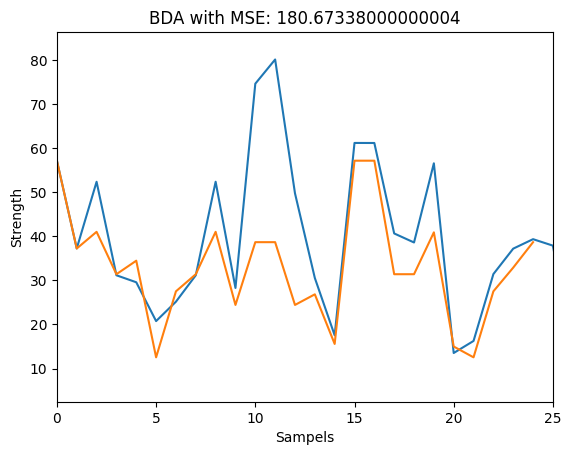

In [499]:
from TL_Regression_Methods.BDA import BDA

bda = BDA(kernel_type='primal', dim=30, lamb=1, mu=0.5, mode='BDA', gamma=1, estimate_mu=False)
mse_bda, y_pre_bda, list_acc = bda.fit_predict(Xs, Ys, Xt[:25], Yt[:25])
print(f'The MSE of BDA is: {mse_bda:.4f}')

plt.plot(Yt.reset_index(drop=True))
plt.plot(y_pre_bda)
plt.xlim(0, 25)
plt.title('BDA with MSE: '+ str(mse_bda))
plt.xlabel('Sampels')
plt.ylabel('Strength')
plt.show()

# ISt so implementiert das es so viele Durchläufe gibt wie Klassen 

The accuracy of JDA is: 194.1282


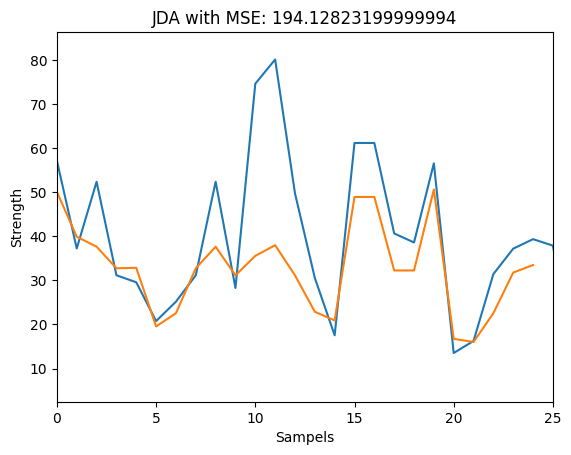

In [491]:
from TL_Regression_Methods.JDA import JDA

jda = JDA(kernel_type='primal', dim=30, lamb=1, gamma=1)
mse_jda, y_pre_jda, list_acc = jda.fit_predict(Xs, Ys, Xt[:25], Yt[:25])
print(f'The accuracy of JDA is: {mse_jda:.4f}')

plt.plot(Yt.reset_index(drop=True))
plt.plot(y_pre_jda)
plt.xlim(0, 25)
plt.title('JDA with MSE: '+ str(mse_jda))
plt.xlabel('Sampels')
plt.ylabel('Strength')
plt.show()

## Baseline

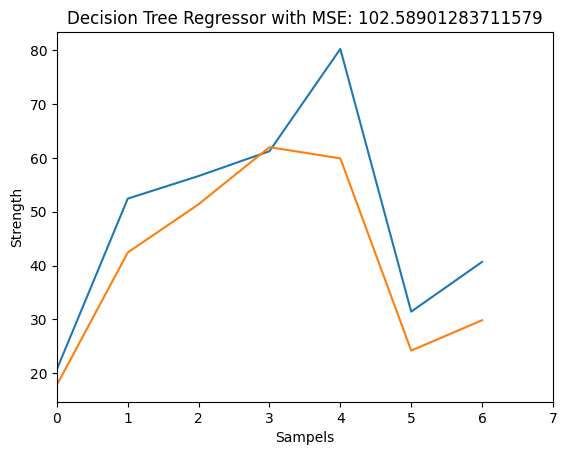

In [540]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn import linear_model

# Train Test Split
X_train, X_test, y_train, y_test= train_test_split(Xt[:25], Yt[:25], random_state=0)

clf = linear_model.Lasso(alpha=0.1)
clf.fit(X_train, y_train)
y_pre_ridge = clf.predict(X_test)
mse_ridge = sklearn.metrics.mean_squared_error(y_test, y_pre_ridge)
results_transfer.append(mse_ridge)

plt.plot(y_test.reset_index(drop=True))
plt.plot(y_pre_ridge)
plt.xlim(0, len(y_target_test))
plt.title('Decision Tree Regressor with MSE: '+ str(mse_ridge))
plt.xlabel('Sampels')
plt.ylabel('Strength')
plt.show()

## Coral

The MSE of Coral is: 1183.8423


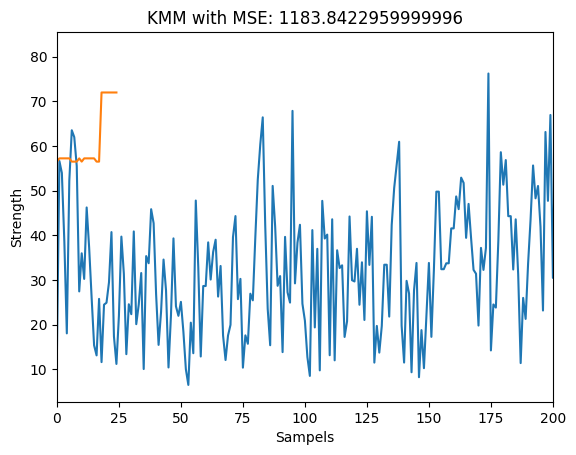

In [482]:
from TL_Regression_Methods.CORAL import CORAL

coral = CORAL()
k = 1
mse_coral, y_pre_coral = coral.fit_predict(Xs, Ys, Xt[:25], Yt[:25], k)
print(f'The MSE of Coral is: {mse_coral:.4f}')

plt.plot(Yt.reset_index(drop=True))
plt.plot(y_pre_coral)
plt.xlim(0, 200)
plt.title('KMM with MSE: '+ str(mse_coral))
plt.xlabel('Sampels')
plt.ylabel('Strength')
plt.show()

MSE using KMM: 231.43


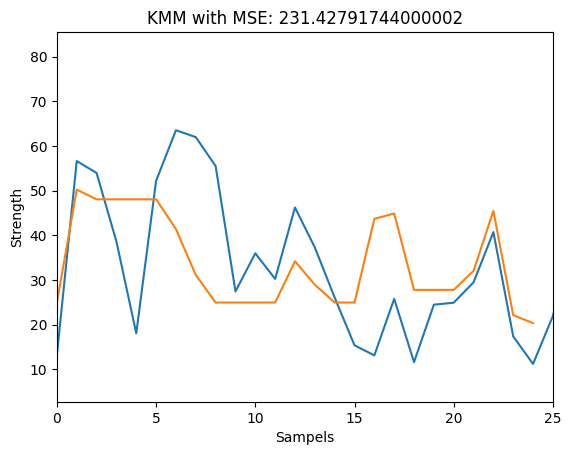

In [479]:
from TL_Regression_Methods.KMM import KMM
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

model = KNeighborsRegressor(n_neighbors=10)
model.fit(Xs, Ys)
y_pre_kmm = model.predict(Xt[:25])
mse_kmm = mean_squared_error(Yt[:25], y_pre_kmm)
print(f'MSE using KMM: {mse_kmm:.2f}')

plt.plot(Yt.reset_index(drop=True))
plt.plot(y_pre_kmm)
plt.xlim(0, len(Xt[:25]))
plt.title('KMM with MSE: '+ str(mse_kmm))
plt.xlabel('Sampels')
plt.ylabel('Strength')
plt.show()

In [169]:
len(df_tar[:300])

300

In [829]:
results_transfer = []
results_transfer_val = []

In [830]:
from TL_Regression_Methods.TwoStageTrAdaBoostR2 import TwoStageTrAdaBoostR2
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Train Test Split
df_train, df_test= train_test_split(df_tar[:25], random_state=0)

# source
n_source1 = len(df_src)
x_source1 = df_src.iloc[:,:-1]
y_source1 = df_src.iloc[:,-1]

# target_train
n_target_train = len(df_train)
x_target_train = df_train.iloc[:,:-1]
y_target_train = df_train.iloc[:,-1]

# target_test
n_target_test = len(df_test)
x_target_test = df_test.iloc[:,:-1]
y_target_test = df_test.iloc[:,-1]

print(len(df_src),len(df_train),len(df_test))

for i in range(1, 30):
    # 4. transfer learning regressiong for the target_train data
    # 4.1 data combination and initial setting specification
    X = np.concatenate((x_source1, x_target_train))
    y = np.concatenate((y_source1, y_target_train))
    sample_size = [n_source1, n_target_train]

    n_estimators = 80
    steps = 10
    fold = 5
    random_state = np.random.RandomState(1)

    regr_1 = TwoStageTrAdaBoostR2(DecisionTreeRegressor(max_depth=5),
                        n_estimators = n_estimators, sample_size = sample_size, 
                        steps = steps, fold = fold, 
                        random_state = random_state)
    regr_1.fit(X, y)
    y_pre_twostageboost = regr_1.predict(x_target_test)
    mse_twostageboost = mean_squared_error(y_target_test, y_pre_twostageboost) 

    results_transfer.append(mse_twostageboost)

    y_pre_twostageboost = regr_1.predict(Xt[25:])
    mse_ridge_val = sklearn.metrics.mean_squared_error(Yt[25:], y_pre_twostageboost)
    results_transfer_val.append(mse_ridge_val)

'''plt.plot(y_target_test.reset_index(drop=True))
plt.plot(y_pre_twostageboost)
plt.xlim(0, 100)
plt.title('TwoStageTrAdaBoostR2 with MSE: '+ str(mse_twostageboost))
plt.xlabel('Sampels')
plt.ylabel('Strength')
plt.show()'''

344 18 7
At step: 7
Binary search's goal not meeted! Value is set to be the available best!
Try reducing the search interval. Current stp interval: 1e-30
At step: 8
Binary search's goal not meeted! Value is set to be the available best!
Try reducing the search interval. Current stp interval: 1e-30
At step: 9
Binary search's goal not meeted! Value is set to be the available best!
Try reducing the search interval. Current stp interval: 1e-30
At step: 7
Binary search's goal not meeted! Value is set to be the available best!
Try reducing the search interval. Current stp interval: 1e-30
At step: 8
Binary search's goal not meeted! Value is set to be the available best!
Try reducing the search interval. Current stp interval: 1e-30
At step: 9
Binary search's goal not meeted! Value is set to be the available best!
Try reducing the search interval. Current stp interval: 1e-30
At step: 6
Binary search's goal not meeted! Value is set to be the available best!
Try reducing the search interval. Curr

"plt.plot(y_target_test.reset_index(drop=True))\nplt.plot(y_pre_twostageboost)\nplt.xlim(0, 100)\nplt.title('TwoStageTrAdaBoostR2 with MSE: '+ str(mse_twostageboost))\nplt.xlabel('Sampels')\nplt.ylabel('Strength')\nplt.show()"

In [770]:
results_transfer

[63.010871978550604,
 45.70008530859942,
 54.299528172314716,
 56.065506828600846,
 62.98485345264801,
 61.65408414227746,
 73.37549587071905,
 55.597160336839174,
 53.58627570478388,
 57.61837649488622,
 57.71276374014625,
 62.50626375902014,
 55.79606956774296,
 32.58594389283577,
 64.40796925100521,
 48.06074404828672,
 57.49712013263927,
 57.311413149973,
 65.90195467645478,
 58.89407833940633,
 53.484156988644465,
 68.1690095324557,
 54.95869922920317,
 40.777096426461696,
 24.996245028941708,
 75.52027160956875,
 64.81914154710151,
 45.61728772865747,
 66.52160902342202]

In [771]:
results_transfer_val

[134.1975528804534,
 123.31482851445813,
 121.65978267699967,
 138.2566541242571,
 136.0650936668095,
 126.58590245063917,
 131.30795460087685,
 125.81765448217291,
 123.587703040068,
 116.9602212200284,
 139.798246938453,
 111.06150836887979,
 123.71598634519167,
 137.8382450480285,
 110.00888718592064,
 120.78980395248453,
 137.80583422465037,
 132.42837622984806,
 109.77885934578984,
 136.68293449505526,
 122.36133494180054,
 132.70604122951218,
 120.71763469050076,
 131.46210139888962,
 142.81170669678036,
 131.38301324021302,
 141.3311519760834,
 123.57365995051066,
 115.05113504282042]

In [831]:
np.mean(results_transfer)

130.26691686727543

In [832]:
np.mean(results_transfer_val)

299.2003031309774

In [877]:
np.mean(results_transfer)

8721473386.575735

In [878]:
np.mean(results_transfer_val)

6578252199.8178425

In [875]:
results_transfer = []
results_transfer_val = []

In [876]:
import sklearn
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split

# Train Test Split
X_train, X_test, y_train, y_test= train_test_split(Xt[:25], Yt[:25], random_state=0)

for i in range(1, 200):
    clf = DecisionTreeRegressor(max_depth=5)
    clf.fit(X_train, y_train)
    y_pre_ridge = clf.predict(X_test)
    mse_ridge = sklearn.metrics.mean_squared_error(y_test, y_pre_ridge)
    results_transfer.append(mse_ridge)

    y_pre_ridge = clf.predict(Xt[25:])
    mse_ridge_val = sklearn.metrics.mean_squared_error(Yt[25:], y_pre_ridge)
    results_transfer_val.append(mse_ridge_val)

'''plt.plot(y_test.reset_index(drop=True))
plt.plot(y_pre_ridge)
plt.xlim(0, len(y_target_test))
plt.title('Decision Tree Regressor with MSE: '+ str(mse_ridge))
plt.xlabel('Sampels')
plt.ylabel('Strength')
plt.show()'''

"plt.plot(y_test.reset_index(drop=True))\nplt.plot(y_pre_ridge)\nplt.xlim(0, len(y_target_test))\nplt.title('Decision Tree Regressor with MSE: '+ str(mse_ridge))\nplt.xlabel('Sampels')\nplt.ylabel('Strength')\nplt.show()"

pur  0.011627906976744186
SVR(C=0.025, kernel='linear')
SVR(C=1, gamma=2)


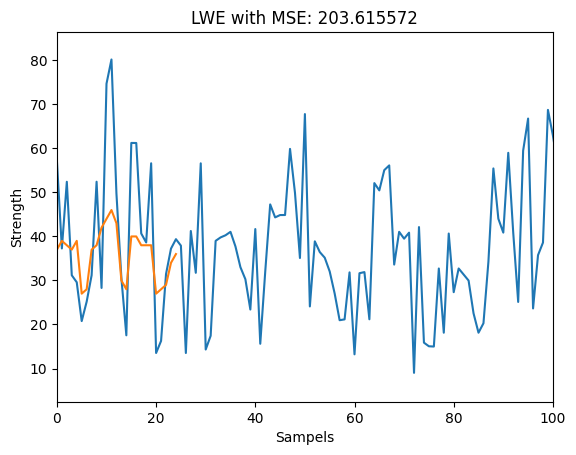

In [512]:
import sklearn
from TL_Regression_Methods.LWE import LWE

model = LWE()
y_pre_lwe = model.fit_predict(Xs, Ys, Xt[:25])
mse_lwe = sklearn.metrics.mean_squared_error(Yt[:25], y_pre_lwe)

plt.plot(Yt.reset_index(drop=True))
plt.plot(y_pre_lwe)
plt.xlim(0, 100)
plt.title('LWE with MSE: '+ str(mse_lwe))
plt.xlabel('Sampels')
plt.ylabel('Strength')
plt.show()

In [14]:
#from TL_Regression_Methods.KMM import KMM
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

#BDA
bda = BDA(kernel_type='primal', dim=30, lamb=1, mu=0.5, mode='BDA', gamma=1, estimate_mu=False)
mse_bda, y_pre_bda, list_acc = bda.fit_predict(Xs, Ys, Xt, Yt)

#JDA
jda = JDA(kernel_type='primal', dim=30, lamb=1, gamma=1)
mse_jda, y_pre_jda, list_acc = jda.fit_predict(Xs, Ys, Xt, Yt)

#Coral
coral = CORAL()
k = 1
mse_coral, y_pre_coral = coral.fit_predict(Xs, Ys, Xt, Yt, k)

#KMM
model = KNeighborsRegressor(n_neighbors=7)
model.fit(Xs, Ys)
y_pre_kmm = model.predict(Xt)
mse_kmm = sklearn.metrics.mean_squared_error(Yt, ypre_kmm)

NameError: name 'BDA' is not defined

## Baseline

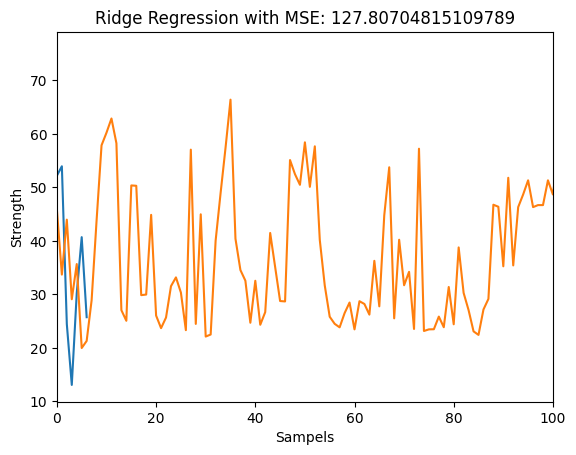

In [530]:
import sklearn
from sklearn.linear_model import Ridge

clf = Ridge(alpha=1.0)
clf.fit(Xt, Yt)
y_pre_ridge = clf.predict(Xt)
mse_ridge = sklearn.metrics.mean_squared_error(Yt, y_pre_ridge)

plt.plot(y_target_test.reset_index(drop=True))
plt.plot(y_pre_ridge)
plt.xlim(0, 100)
plt.title('Ridge Regression with MSE: '+ str(mse_ridge))
plt.xlabel('Sampels')
plt.ylabel('Strength')
plt.show()

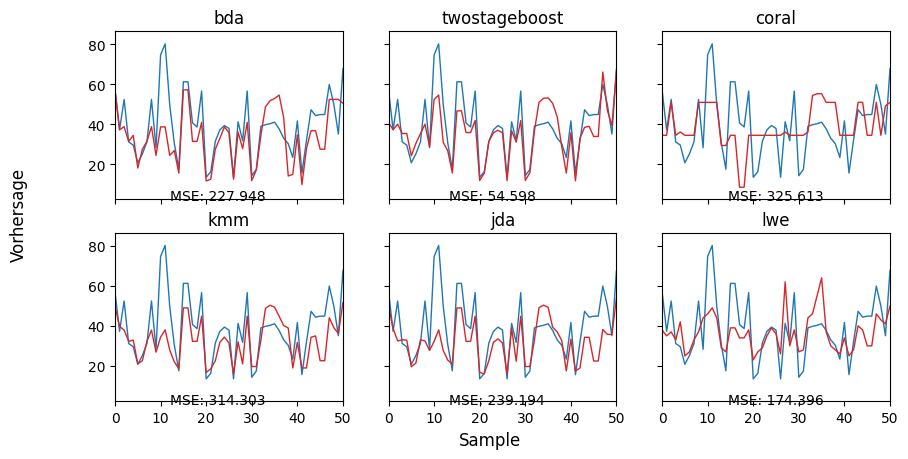

In [81]:
import sys
modname = globals()['__name__']
modobj  = sys.modules[modname]

metrics= ['bda', 'jda', 'coral', 'kmm','twostageboost','lwe']
colours= ['#1f77b4', '#2ca02c', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf','#1f77b4']
hor= [0,1,2,0,1,2]
ver= [0,1,0,1,0,1]

fig, axs = plt.subplots(2, 3)

c = 0
for i in metrics:
    axs[ver[c], hor[c]].plot(Yt.reset_index(drop=True), c='#1f77b4', label=i, linewidth=1)
    axs[ver[c], hor[c]].plot(getattr(modobj, "y_pre_"+ str(i)), c='#d62728', label=i, linewidth=1)
    axs[ver[c], hor[c]].set_title(i)
    axs[ver[c], hor[c]].set_xlim([0, 50])
    axs[ver[c], hor[c]].text(hor[c]*1.2+12, ver[c]*-1.2+2.15, 'MSE: '+ str(round(getattr(modobj, "mse_"+ str(i)),3)) )
    c+=1

fig.supxlabel('Sample')
fig.supylabel('Vorhersage')
fig.set_figwidth(10) 

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()